In [34]:
!pip install geopandas
!pip install descartes

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Table of contents

* [1. Loading libraries and data](#1.-Loading-libraries-and-data)
  * [1.1 Loading libraries](#2.1-Loading-libraries)
  * [1.2 Loading helper functions](#2.2-Loading-helper-functions)
  * [1.3 The listings and listing details files](#2.3-The-listings-and-listing-details-files)
* [2. Data exploration](#2.-Data-exploration)

# 1. Loading libraries and data
## 1.1 Loading libraries

In [95]:
# Importing necessery libraries for analysis of the dataset
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

## to deal with geo data
import geopandas as gpd

## Parameterizing libraries
sns.set()
plt.style.use('fivethirtyeight')

## 1.2 Loading helper functions

In [124]:
# Helpers functions

## Count missing data and how percentage
def show_missing_data(dataframe):
    if not isinstance(dataframe, pd.DataFrame):
        raise TypeError('You must pass a pandas dataframe')
    total = dataframe.isnull().sum().sort_values()
    percent = round((dataframe.isnull().sum())/dataframe.count().sort_values(ascending=False) * 100, 2)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'], sort=False).sort_values('Total', ascending=False)
    return missing_data.head(missing_data.shape[0])

def remove_outliers(dataframe, column, distance):
    cleaned = dataframe[np.abs(dataframe[column] - dataframe[column].mean()) <= (distance * dataframe[column].std())]
    return cleaned

## 1.2 Loading data

In [3]:
raw_data = pd.read_csv('data/AB_NYC_2019.csv')
nRow, nCol = raw_data.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 48895 rows and 16 columns


In [136]:
# Let's take a quick look at what the data looks like:
raw_data.head(5)

,id,name,host_id,host_name,district,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [8]:
#Review the data types
raw_data.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

After looking at the head we noticed NaN values, therefore need to examine missing values further before continuing with analysis

In [107]:
# Understanding missing data
## Using 'showMissingData' function will show us how many nulls
## are found in each column and how representative they are in dataset
showMissingData(raw_data)

,Total,Percent
last_review,10052,25.88
reviews_per_month,10052,25.88
host_name,21,0.04
name,16,0.03
id,0,0.00
host_id,0,0.00
district,0,0.00
neighbourhood,0,0.00
latitude,0,0.00
longitude,0,0.00


In this case, missing data that does not need too much treatment.
Looking into the nature of our dataset columns "name" and "host_name" are irrelevant.
Columns "last_review" and "review_per_month" need very simple handling:
 * "last_review" is date; if there were no reviews for the listing - date simply will not exist.
 * "review_per_month" column we can simply append it with 0.0 for missing values;
 
 Let's proceed with removing columns that are not important and handling of missing data.

In [82]:
# Making a new instance of our data
airbnb = raw_data.copy()

# Dropping columns that are not significant or could be unethical (names)
airbnb.drop(['id','host_name','last_review'], axis=1, inplace=True)

In [ ]:
# Replacing all NaN values in 'reviews_per_month' with 0
airbnb.fillna({'reviews_per_month':0}, inplace=True)
# Testing changes
airbnb.reviews_per_month.isnull().sum()

In [141]:
non_priced = airbnb.index[raw_data.price == 0]
airbnb.drop(non_priced, inplace=True)

In [108]:
# Renaming a column to accurately reflect districts
airbnb.rename(columns={'neighbourhood_group':'district'}, inplace=True)

# Exploring and Visualizing Data
Analyzing its statistics and visualizing the values of features and correlations between different features.

We are going to explore the dataframe from left to right to make sure we learn as much as we can about our dataset.

Let's see what we can learn looking to the column host id. Are there host with many listings?

In [151]:
# Creating a serie with 10 biggest hosts
topten_hosts = airbnb.host_id.value_counts().head(10)
topten_hosts

219517861    327
107434423    232
30283594     121
137358866    103
16098958      96
12243051      96
61391963      91
22541573      87
200380610     65
1475015       52
Name: host_id, dtype: int64

[Text(0, 0, '219517861'),
 Text(0, 0, '107434423'),
 Text(0, 0, '30283594'),
 Text(0, 0, '137358866'),
 Text(0, 0, '16098958'),
 Text(0, 0, '12243051'),
 Text(0, 0, '61391963'),
 Text(0, 0, '22541573'),
 Text(0, 0, '200380610'),
 Text(0, 0, '1475015')]

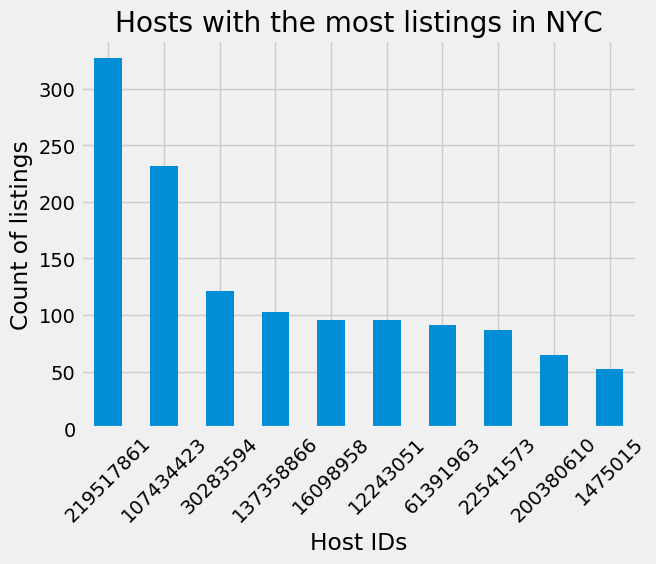

In [215]:
topten_viz = topten_hosts.plot(kind='bar')
topten_viz.set_title('Hosts with the most listings in NYC')
topten_viz.set_ylabel('Count of listings')
topten_viz.set_xlabel('Host IDs')
topten_viz.set_xticklabels(topten_viz.get_xticklabels(), rotation=45)

In [12]:
# Get a count by district
district_count = airbnb.groupby('district').agg('count').reset_index()
district_count.head()

,district,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Bronx,1091,1090,1091,1090,1091,1091,1091,1091,1091,1091,1091,876,876,1091,1091
1,Brooklyn,20104,20098,20104,20095,20104,20104,20104,20104,20104,20104,20104,16447,16447,20104,20104
2,Manhattan,21661,21652,21661,21652,21661,21661,21661,21661,21661,21661,21661,16632,16632,21661,21661
3,Queens,5666,5666,5666,5664,5666,5666,5666,5666,5666,5666,5666,4574,4574,5666,5666
4,Staten Island,373,373,373,373,373,373,373,373,373,373,373,314,314,373,373


In [25]:
# Dropping useless columns
district_count.drop(['name', 'host_id', 'host_name', 'neighbourhood',
                     'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
                     'number_of_reviews', 'last_review', 'reviews_per_month',
                     'calculated_host_listings_count', 'availability_365'],
                    axis=1, inplace=True)

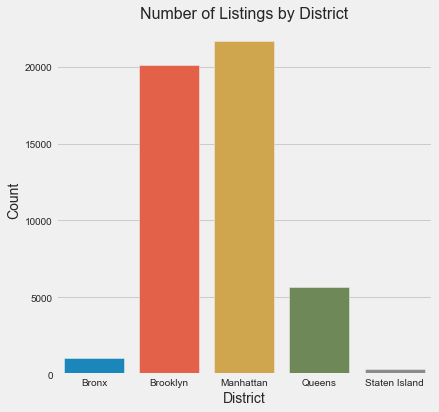

In [109]:
#Plot the count by district
fig, ax1 = plt.subplots(1,1, figsize=(6,6))
sns.barplot(x='district', y='id', data=district_count, ax=ax1)

ax1.set_title('Number of Listings by District', fontsize=16)
ax1.set_xlabel('District', fontsize=14)
ax1.set_ylabel('Count', fontsize=14)
ax1.tick_params(axis='both', labelsize=10)

In [18]:
# Here we are using geopandas to bring in a base layer of NYC districts
nyc = gpd.read_file(gpd.datasets.get_path('nybb'))
nyc.head()

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,(POLYGON ((970217.0223999023 145643.3322143555...
1,4,Queens,896344.047763,3.045213e+09,(POLYGON ((1029606.076599121 156073.8142089844...
2,3,Brooklyn,741080.523166,1.937479e+09,(POLYGON ((1021176.479003906 151374.7969970703...
3,1,Manhattan,359299.096471,6.364715e+08,(POLYGON ((981219.0557861328 188655.3157958984...
4,2,Bronx,464392.991824,1.186925e+09,(POLYGON ((1012821.805786133 229228.2645874023...


In [29]:
# Renaming the column to district to join the data to it 
nyc.rename(columns={'BoroName':'district'}, inplace=True)

# Joing data
district_count__geo = nyc.merge(district_count, on='district')

# Renaming column id to accurately reflect count
district_count__geo.rename(columns={'id':'count'}, inplace=True)

In [30]:
district_count__geo.head()

,BoroCode,district,Shape_Leng,Shape_Area,geometry,count
0,5,Staten Island,330470.010332,1.623820e+09,(POLYGON ((970217.0223999023 145643.3322143555...,373
1,4,Queens,896344.047763,3.045213e+09,(POLYGON ((1029606.076599121 156073.8142089844...,5666
2,3,Brooklyn,741080.523166,1.937479e+09,(POLYGON ((1021176.479003906 151374.7969970703...,20104
3,1,Manhattan,359299.096471,6.364715e+08,(POLYGON ((981219.0557861328 188655.3157958984...,21661
4,2,Bronx,464392.991824,1.186925e+09,(POLYGON ((1012821.805786133 229228.2645874023...,1091


(905464.739038086, 1075092.8783935548, 112485.76063504723, 280480.41425942676)

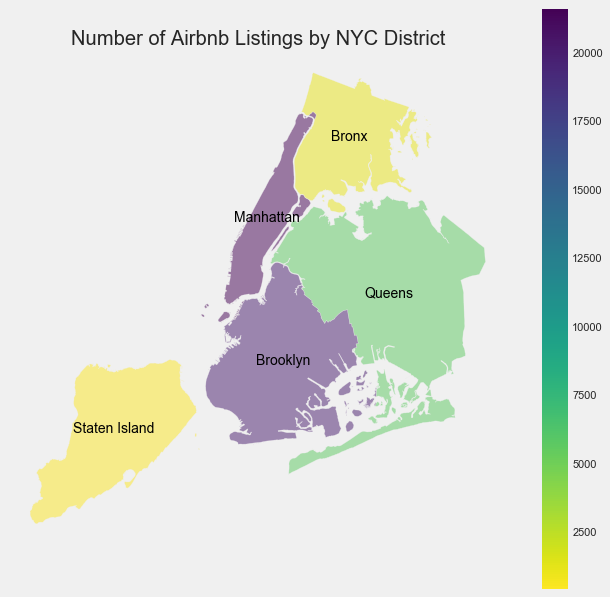

In [37]:
#Plot the count by district into a map
fig,ax = plt.subplots(1,1, figsize=(10,10))
district_count__geo.plot(column='count', cmap='viridis_r', alpha=.5, ax=ax, legend=True)
district_count__geo.apply(lambda x: ax.annotate(s=x.district, color='black', xy=x.geometry.centroid.coords[0],ha='center'), axis=1)
plt.title("Number of Airbnb Listings by NYC District")
plt.axis('off')

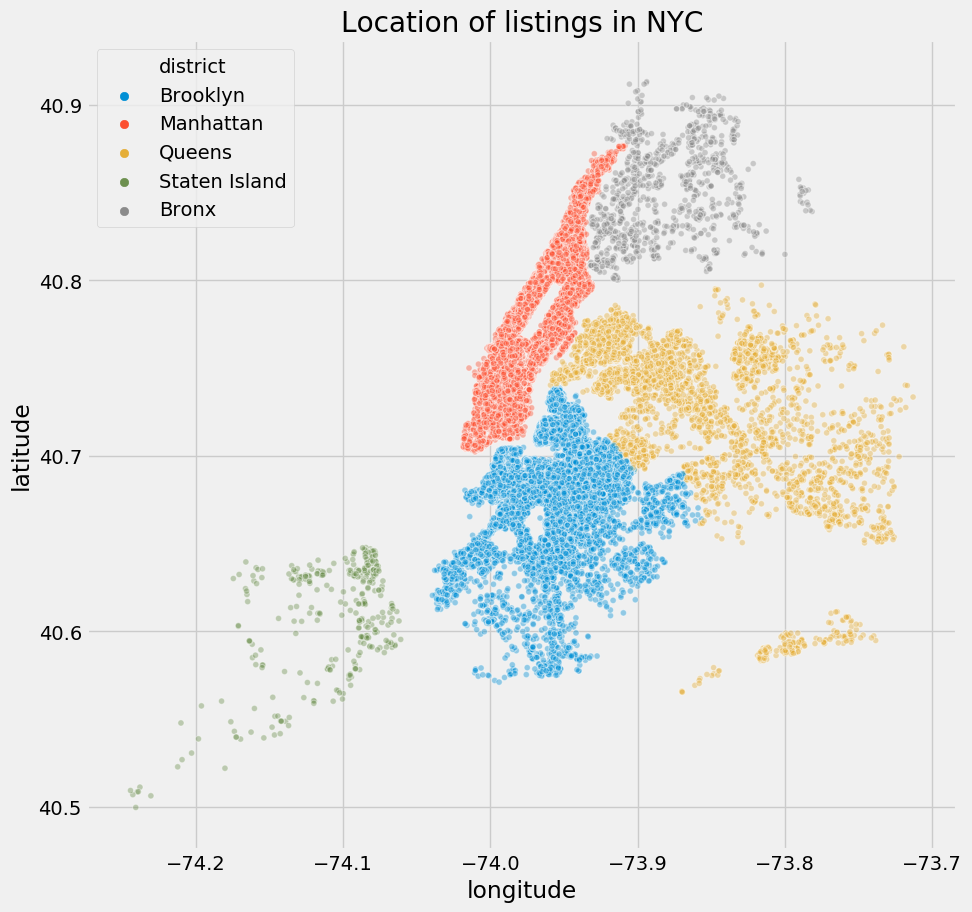

In [164]:
# Reviewing the listings by location
plt.figure(figsize=(10,10))
plt.title('Location of listings in NYC')
sns.scatterplot(x='longitude', y='latitude', hue='district', alpha=0.4, s=20, data=airbnb)

In [126]:
# Checking outliers amount using std distance
print(len(raw_data) - len(remove_outliers(raw_data, 'price', 2)))
print(len(raw_data) - len(remove_outliers(raw_data, 'price', 3)))

767
388


In [131]:
# Creating subsets using 3 std distance
airbnb_3std = remove_outliers(raw_data, 'price', 3)

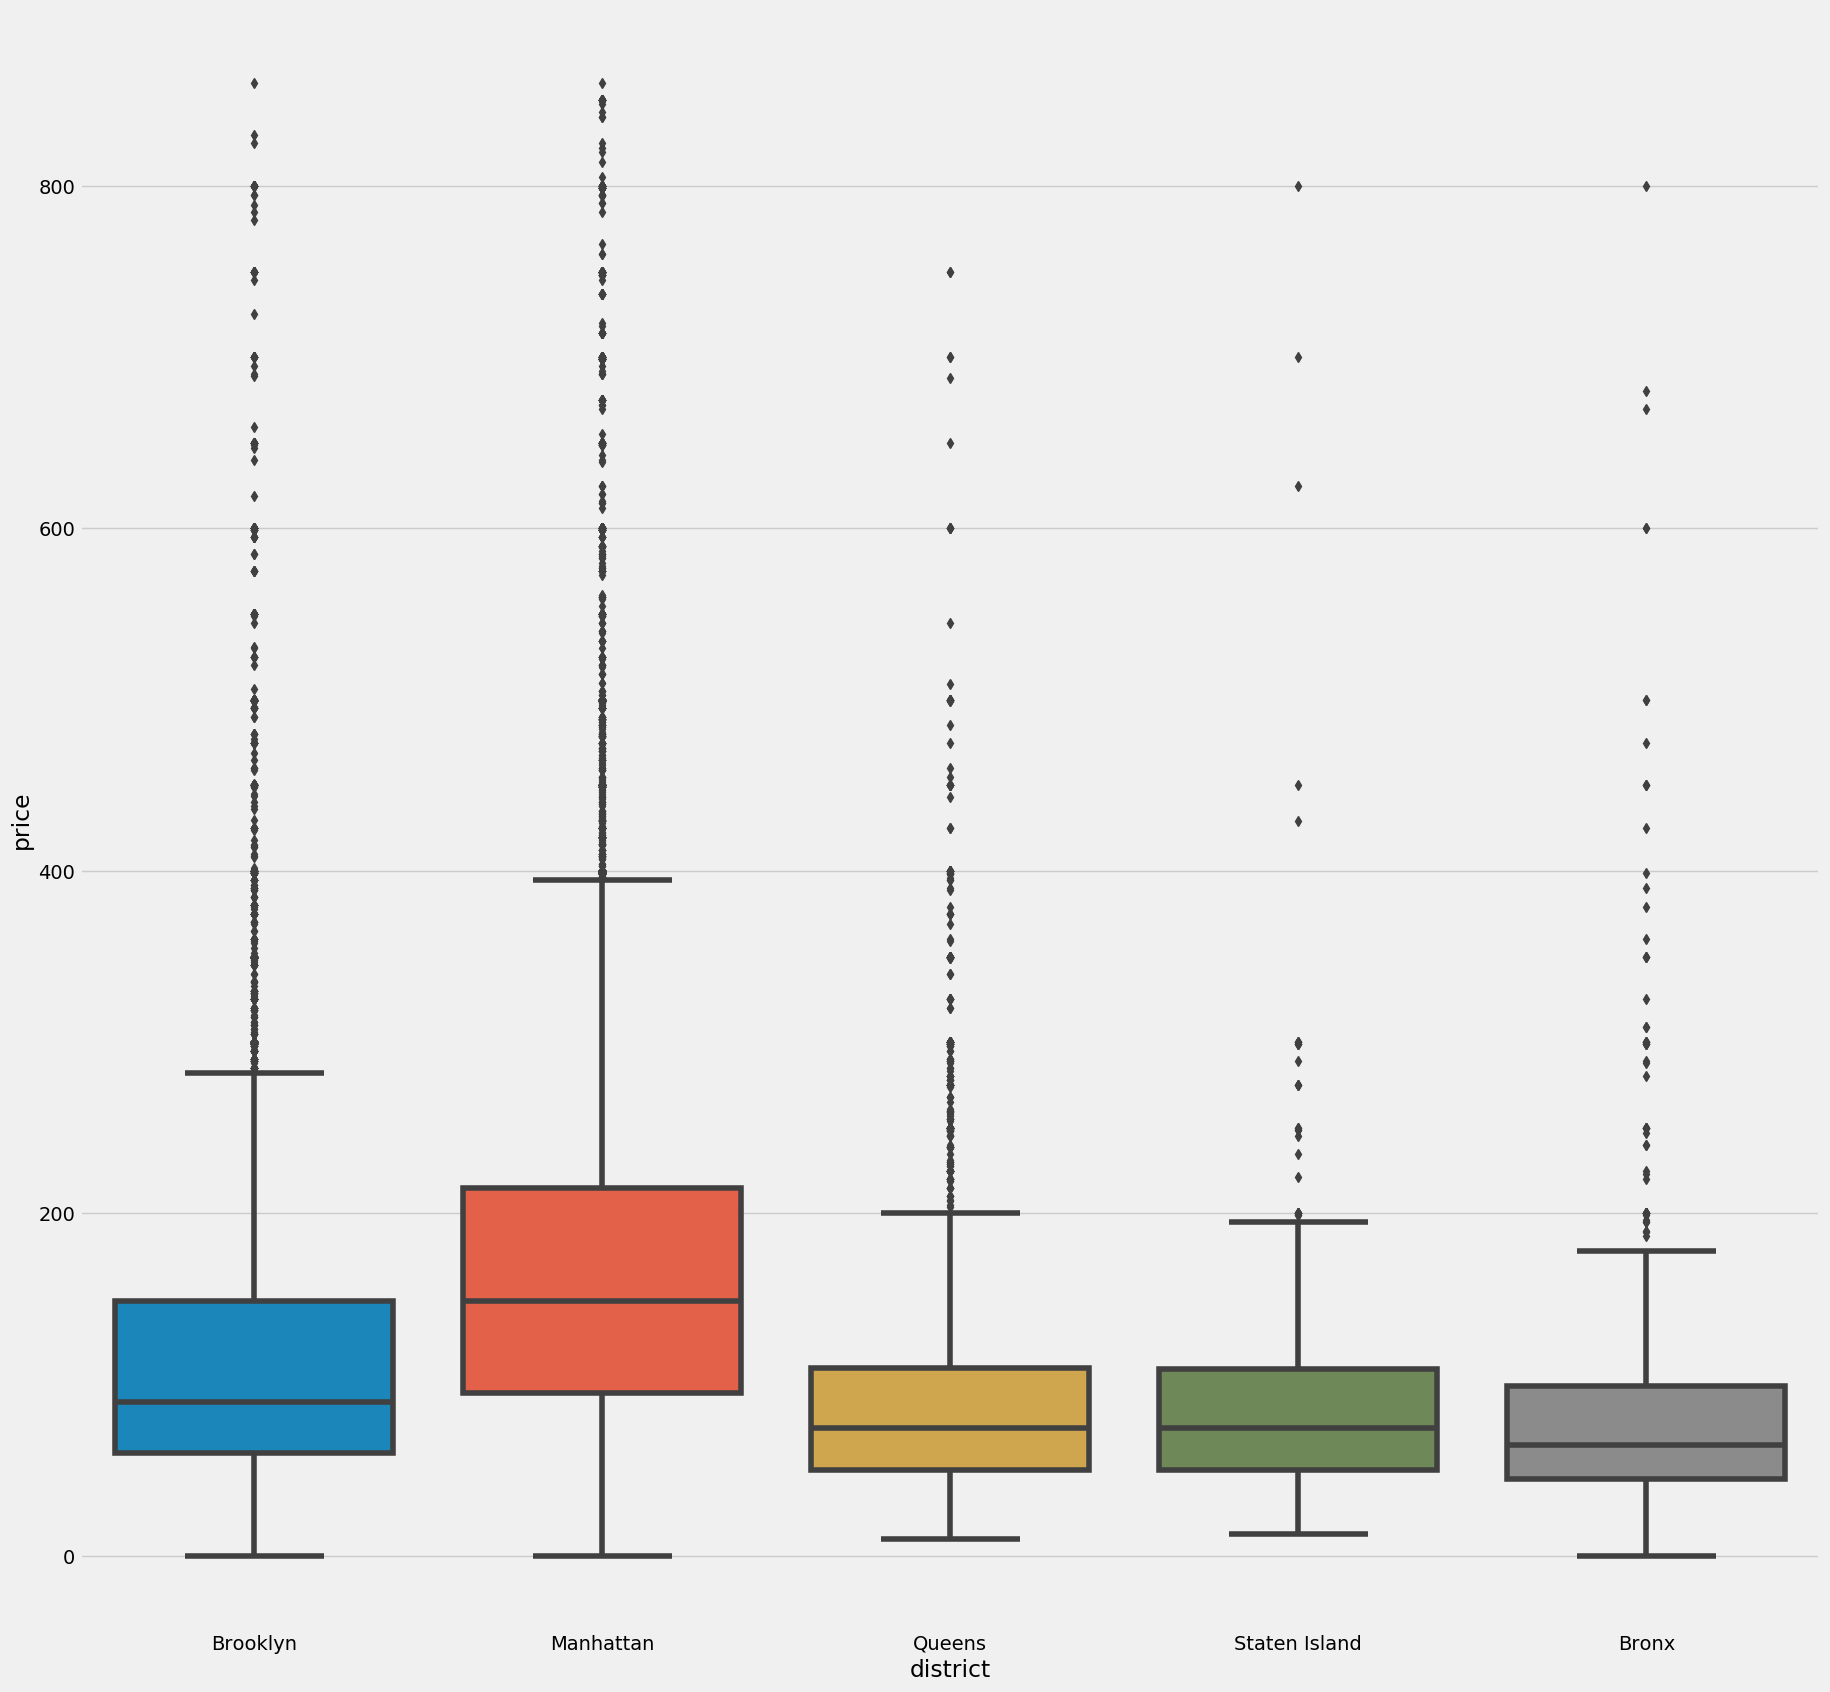

In [200]:
#Plot the price range of each district
fig, ax = plt.subplots(1,1, figsize=(20,20))
sns.boxplot(x='district', y='price', data=airbnb_3std)

The data for price is highly skewed. The figure suggests that there's a possibility of distinction between the price ranges by listing features (maybe for room types?)

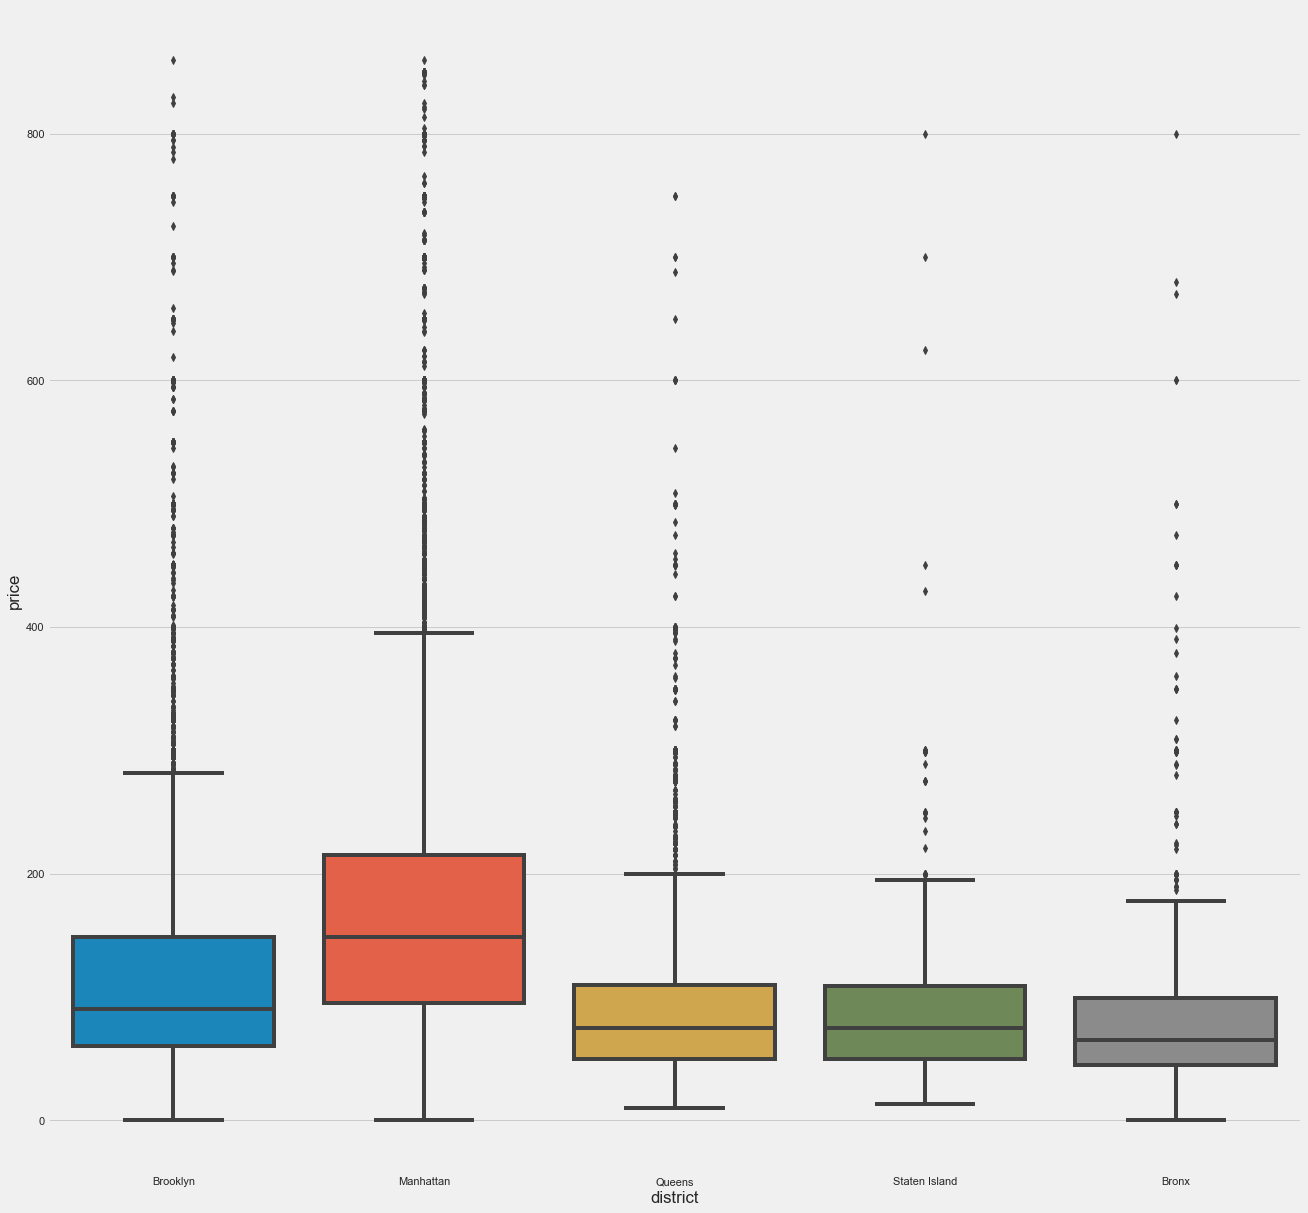

In [132]:
# Plot the price range of each district for private rooms
fig, ax = plt.subplots(1,1, figsize=(20,20))
sns.boxplot(x='district', y='price', data=airbnb_3std)

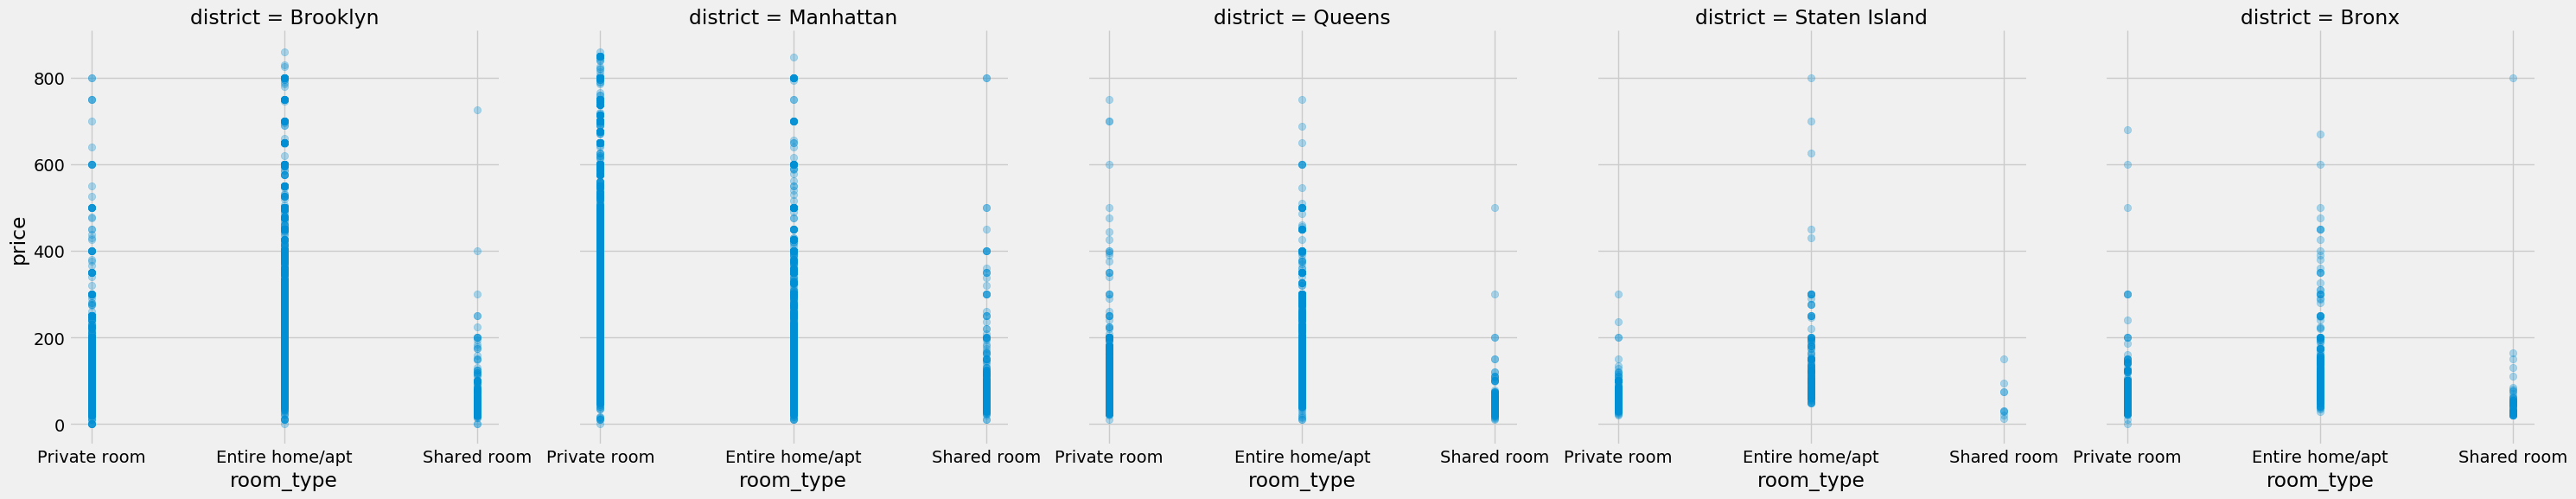

In [187]:
g = sns.FacetGrid(airbnb_3std, col="district", col_wrap=5, height=6)
g.map(plt.scatter, "room_type", "price", alpha=.3)

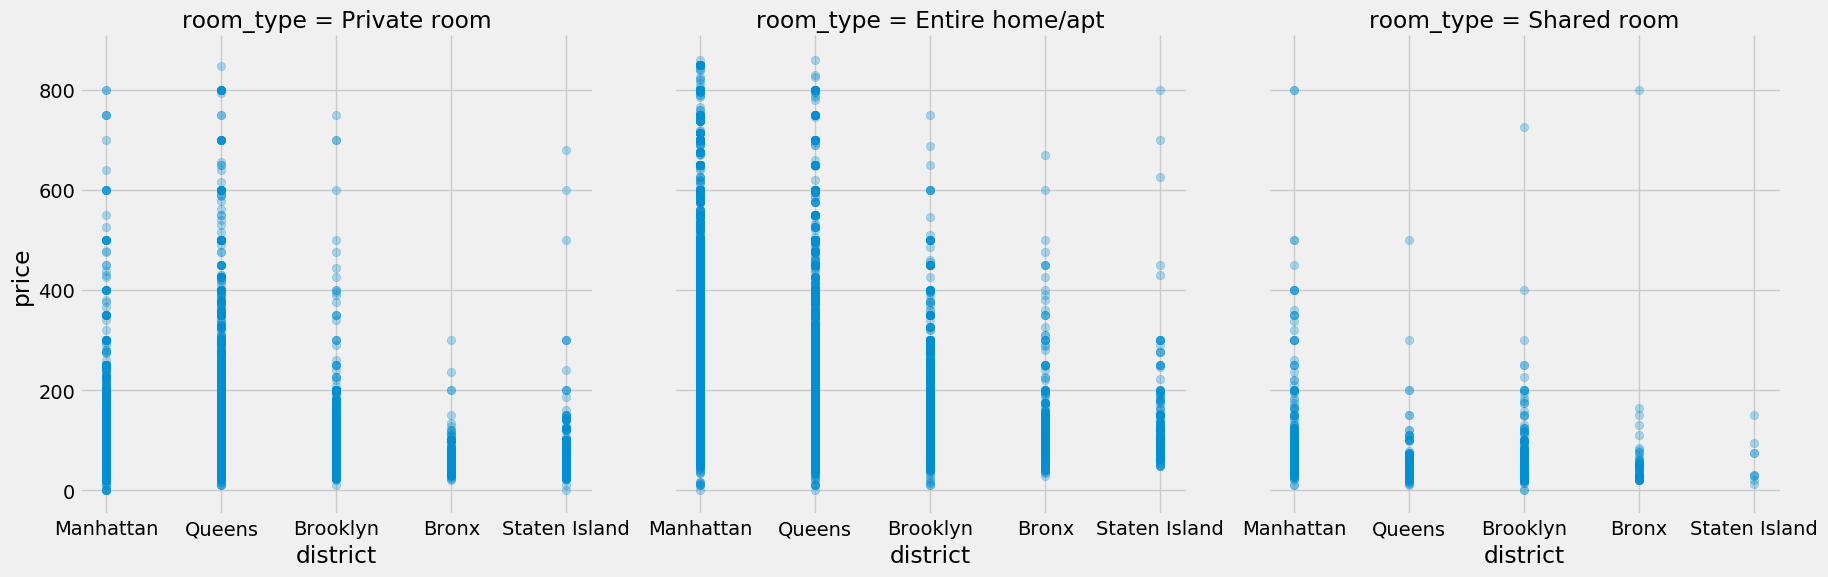

In [190]:
g = sns.FacetGrid(airbnb_3std, col="room_type", col_wrap=5, height=6)
g.map(plt.scatter, "district", "price", alpha=.3)

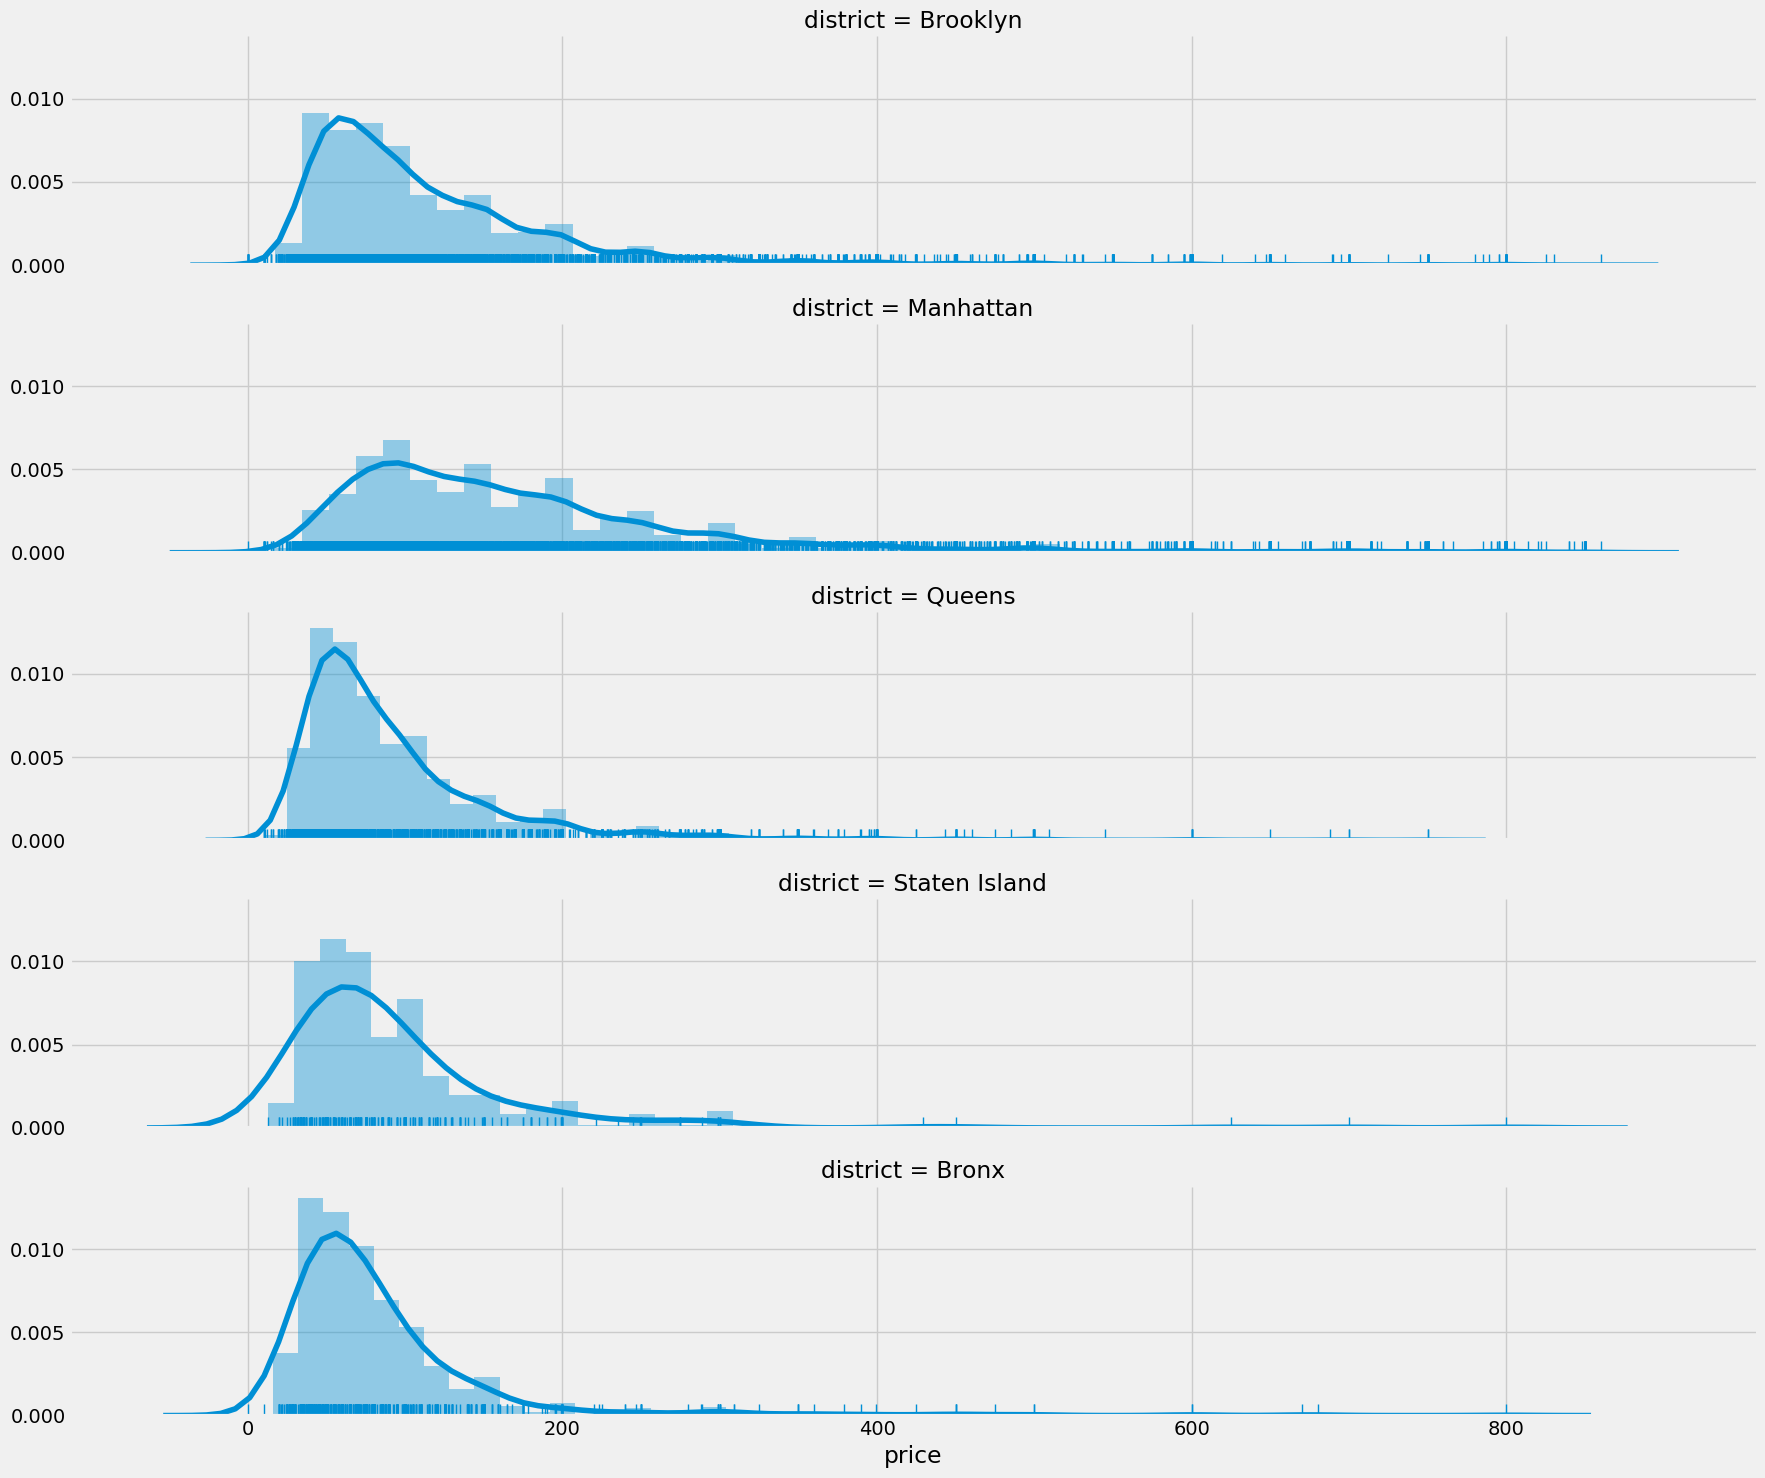

In [213]:
g = sns.FacetGrid(airbnb_3std, row="district", height=3, aspect=6)
g.map(sns.distplot, "price", hist=True, rug=True);

#### Price Distribution of Airbnb in Brooklyn
The price distribution of Airbnb in Brooklyn averages around 50-500 dollars per night depending upon the neighbourhood.

#### Price Distribution of Airbnb in Manhattan
The price distribution of Airbnb in Manhattan averages around 100-800 dollars per night depending upon the neighbourhood.

#### Price Distribution of Airbnb in Queens
The price distribution of Airbnb in Queens averages around 100-500 dollars per night depending upon the neighbourhood.

#### Price Distribution of Airbnb in Staten Island
The price distribution of Airbnb in Staten Islands averages around 50-400 dollars per night depending upon the neighbourhood.

#### Price Distribution of Airbnb in Bronx
The price distribution of Airbnb in Bronx averages around 50-250 dollars per night depending upon the neighbourhood.

b-a-t
